# **CNN - Chest X-ray Dataset**

> Chest X-ray 데이터셋은 아래 3가지로 분류
- Normal(정상)
- Viral Pneumonia(폐렴)
- COVID-19

Soruce: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

## [Step 01] 라이브러리 로딩

In [26]:
import os
import shutil
import random
import torch

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data

import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('PyTorch version:', torch.__version__)

PyTorch version: 1.13.1+cu116


In [27]:
!nvidia-smi

Thu Feb  9 13:38:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## [Step 02] 데이터셋 다운로드

In [28]:
!git clone https://github.com/hmjeon/Lec-DLCV.git

Cloning into 'Lec-DLCV'...
remote: Enumerating objects: 1572, done.
remote: Counting objects: 100% (446/446), done.
remote: Compressing objects: 100% (422/422), done.
remote: Total 1572 (delta 30), reused 437 (delta 22), pack-reused 1126
Receiving objects: 100% (1572/1572), 185.38 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Updating files: 100% (1523/1523), done.


In [29]:
%cd Lec-DLCV/dataset/dataset_chestxray/

/content/Lec-DLCV/dataset/dataset_chestxray/Lec-DLCV/dataset/dataset_chestxray


> 데이터로더 생성

In [30]:
class_names = ['normal', 'viral', 'covid']
root_dir = '.'

In [31]:
class ChestXRayDataset(data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [32]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [33]:
train_dirs = {
    'normal': f'{root_dir}/normal',
    'viral': f'{root_dir}/viral',
    'covid': f'{root_dir}/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 100 normal examples
Found 100 viral examples
Found 100 covid examples


In [34]:
test_dirs = {
    'normal': f'{root_dir}/test/normal',
    'viral': f'{root_dir}/test/viral',
    'covid': f'{root_dir}/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 20 normal examples
Found 20 viral examples
Found 20 covid examples


In [35]:
batch_size = 6

dl_train = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 50
Number of test batches 10


## [Step 03] 데이터 가시화

In [36]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

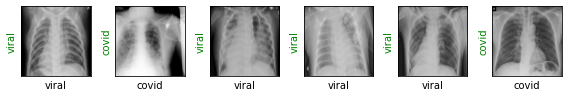

In [37]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

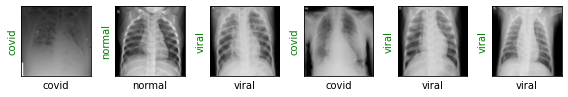

In [38]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

## [Step 04] 네트워크 모델 정의

In [39]:
resnet18 = models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
resnet18.fc = nn.Linear(in_features=512, out_features=3)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=3e-5)

In [41]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

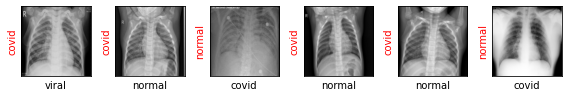

In [42]:
show_preds()

## [Step 05] 네트워크 모델 학습

In [43]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # Set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # Set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/4
Evaluating at step 0
Validation Loss: 1.2049, Accuracy: 0.2167


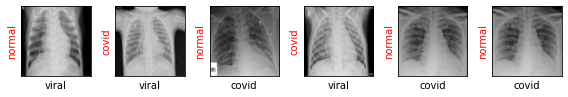

Evaluating at step 20
Validation Loss: 0.8938, Accuracy: 0.7167


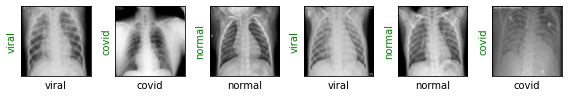

Evaluating at step 40
Validation Loss: 0.7032, Accuracy: 0.7333


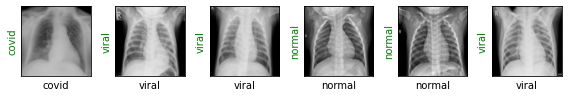

Training Loss: 0.7394
Starting epoch 2/4
Evaluating at step 0
Validation Loss: 0.3958, Accuracy: 0.9333


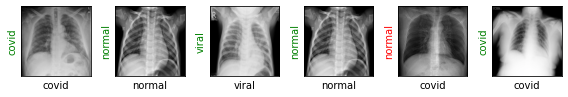

Evaluating at step 20
Validation Loss: 0.3758, Accuracy: 0.9167


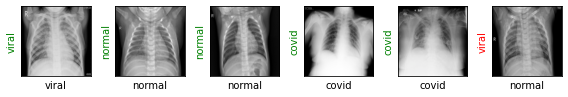

Evaluating at step 40
Validation Loss: 0.2626, Accuracy: 0.9500


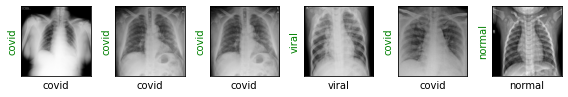

Training Loss: 0.3768
Starting epoch 3/4
Evaluating at step 0
Validation Loss: 0.2075, Accuracy: 0.9667


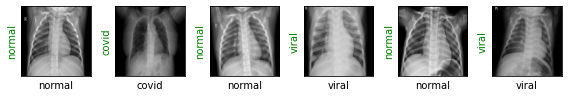

Evaluating at step 20
Validation Loss: 0.2721, Accuracy: 0.9500


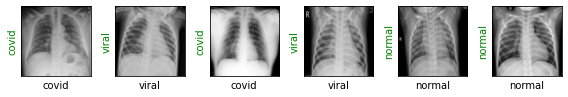

Evaluating at step 40
Validation Loss: 0.2167, Accuracy: 0.9667


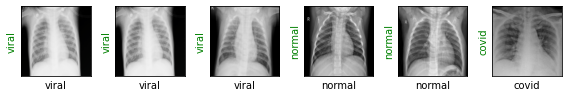

Training Loss: 0.2649
Starting epoch 4/4
Evaluating at step 0
Validation Loss: 0.1361, Accuracy: 1.0000


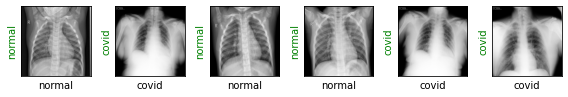

Performance condition satisfied, stopping..
CPU times: user 4min 9s, sys: 5.71 s, total: 4min 15s
Wall time: 4min 30s


In [44]:
%%time

train(epochs=4)

## [Step 06] 모델 검증

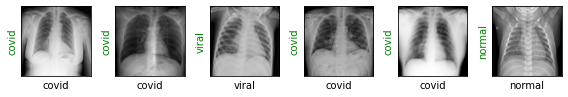

In [45]:
show_preds()

## [Step 07] 네트워크 모델 저장

In [46]:
torch.save(resnet18.state_dict(), 'covid_classifier.pt')

## [Step 08] 이미지 추론

In [47]:
# Load the model and set in eval
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)

resnet18.load_state_dict(torch.load('covid_classifier.pt'))
resnet18.eval()


def predict_image_class(image_path):
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image)
    
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = resnet18(image)[0]
    probabilities = torch.nn.Softmax(dim=0)(output)
    probabilities = probabilities.cpu().detach().numpy()
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = class_names[predicted_class_index]
    return probabilities, predicted_class_index, predicted_class_name

In [48]:
image_path = 'viral/Viral Pneumonia-1.png'

probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [0.00327811 0.9902683  0.00645358]
Predicted class index: 1
Predicted class name: viral
